# Data collection and preprocessing

In [1]:
import ee
import geemap


Map = geemap.Map()

imgcol = ee.ImageCollection("COPERNICUS/S2");

#Polygon Study area with coordinates
SA = ee.Geometry.Polygon(
        [[[77.44504111066439, 27.133452708222787],
          [77.44504111066439, 27.073245342079318],
          [77.5248636509476, 27.073245342079318],
          [77.5248636509476, 27.133452708222787]]], None, False);


spatialFiltered = imgcol.filterBounds(SA); #Filter by area, You can input either SA or rectangle here

year = "2016"

#Enter Dates Here!
jancol = spatialFiltered.filterDate(year+'-01-01', year+'-01-31'); #January
febcol = spatialFiltered.filterDate(year+'-02-01', year+'-02-28'); #February
marchcol = spatialFiltered.filterDate(year+'-03-01', year+'-03-31'); #March


#Cloud mask function
def maskS2clouds(image):
    qa = image.select('QA60');


    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0));

    return image.updateMask(mask).divide(10000);



#Making cloud free images
cfreejan = jancol.map(maskS2clouds);
cfreesinglejan = cfreejan.median()
#print('cfreesinglejan',cfreesinglejan)

cfreefeb = febcol.map(maskS2clouds);
cfreesinglefeb = cfreefeb.median()
#print('cfreesinglefeb',cfreesinglefeb)

cfreemarch = marchcol.map(maskS2clouds);
cfreesinglemarch = cfreemarch.median()
#print('cfreesinglemarch',cfreesinglemarch)


#Calculating NDVIs for each month
ndvijan = cfreesinglejan.normalizedDifference(['B5', 'B4']).rename('NDVIjan');
ndvifeb = cfreesinglefeb.normalizedDifference(['B5', 'B4']).rename('NDVIfeb');
ndvimarch = cfreesinglemarch.normalizedDifference(['B5', 'B4']).rename('NDVImarch');


#Taking empty image instance and adding three NDVIs to it
ndvicomp = ee.Image().addBands([ndvijan, ndvifeb, ndvimarch]);


#-----------------------------------------------VISULISATION-------------------------------------------------------------
#Center map over Bharatpur area
Map.setCenter(77.4813,27.1029, 13);
scale = 30


#Simple RGB 
rgbVis = {'min': 0.0,'max': 0.3,'bands': ['B4', 'B3', 'B2'],'gamma': [0.95, 1.1, 1], 'scale':scale}
#Visulise Cloud free RGB image
Map.addLayer(cfreesinglemarch.clip(SA), rgbVis, 'RGB');


#NDVI of a month
ndviParams = {'min': 0, 'max': 0.2, 'palette': ['blue', 'white', 'green'], 'scale':scale};

#NDVI for january
Map.addLayer(ndvicomp.select('NDVIjan').clip(SA), ndviParams, 'NDVIJan');
#NDVI for february
Map.addLayer(ndvicomp.select('NDVIfeb').clip(SA), ndviParams, 'NDVIFeb');
#NDVI for march
Map.addLayer(ndvicomp.select('NDVImarch').clip(SA), ndviParams, 'NDVIMarch');


#False colour composite of a month
false = {'bands': ['B8', 'B4', 'B3'],'min': 0,'max': 0.5,'gamma': [0.95, 1.1, 1], 'scale':scale};


#Map.addLayer(cfreesinglejan.clip(SA), false, 'FCCJan')
#Map.addLayer(cfreesinglefeb.clip(SA), false, 'FCCFeb')
#Map.addLayer(cfreesinglemarch.clip(SA), false, 'FCCMarch')


#NDVI colour composite
ndvicc = {'bands': ['NDVIjan', 'NDVIfeb', 'NDVImarch'],'min': 0,'max': 0.5,'gamma': [0.85, 1.8, 0.8], 'scale':scale};

Map.addLayer(ndvicomp.clip(SA), ndvicc, 'NDVI Multitemporal')


mustard = ee.Geometry.Rectangle(77.4883, 27.1172, 77.5034, 27.1032)
Map.addLayer(mustard)

wheat = ee.Geometry.Rectangle(77.4619, 27.0800, 77.4684, 27.0750)
Map.addLayer(wheat)

nonc = ee.Geometry.Rectangle(77.4588, 27.0932, 77.4627, 27.0895)
Map.addLayer(nonc)

Map.centerObject(mustard);





#Mustard
# 77.4883, 27.1172    

# 77.5034, 27.1032

#################################
#Wheat
#77.4619, 27.0800

#77.4684, 27.0750


#################################
#Non crops
#77.4588, 27.0932

#77.4627, 27.0895

#1 - mustard
#2 -wheat
#3 - non crops
features = [
   ee.Feature(mustard, {'name': 1}),
    ee.Feature(wheat, {'name': 2}),
    ee.Feature(nonc, {'name': 3}),

]

flist = ee.FeatureCollection(features);


# print(flist.first().getInfo())

bandtraining = ['NDVIjan', 'NDVIfeb', 'NDVImarch']
label = 'name'

# Overlay the points on the imagery to get training.
training = ndvicomp.select(bandtraining).sampleRegions(**{
  'collection': flist,
  'properties': [label],
  'scale': 30
})
print("Okay!")


Okay!


# Plotting NDVI graph for each month

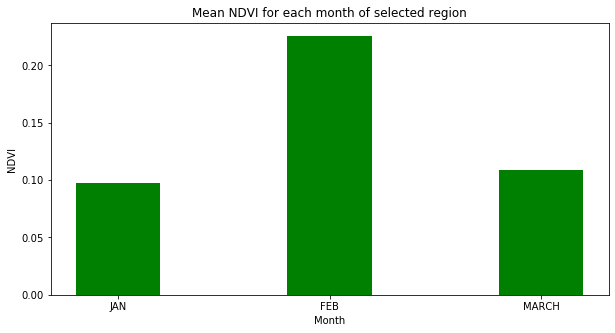

In [32]:
#Calculating mean of each month
import numpy as np
import matplotlib.pyplot as plt

janmean = ndvicomp.select('NDVIjan').reduceRegion(reducer=ee.Reducer.mean(),geometry=SA,scale=scale);
febmean = ndvicomp.select('NDVIfeb').reduceRegion(reducer=ee.Reducer.mean(),geometry=SA,scale=scale);
marchmean = ndvicomp.select('NDVImarch').reduceRegion(reducer=ee.Reducer.mean(),geometry=SA,scale=scale);





# creating the data to plot
data = {'JAN':janmean.getInfo()['NDVIjan'], 'FEB':febmean.getInfo()['NDVIfeb'], 'MARCH':marchmean.getInfo()['NDVImarch']}
courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='green',width = 0.4)
plt.xlabel("Month")
plt.ylabel("NDVI")
plt.title("Mean NDVI for each month of selected region")
plt.show()




# Downloading of data

In [ ]:
#Downloading the Data

import os
dscale = 30

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

#FCC for each month
#geemap.ee_export_image(cfreesinglejan.clip(SA), filename = os.path.join(out_dir, 'cloudfreejanfcc.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(cfreesinglefeb.clip(SA), filename = os.path.join(out_dir, 'cloudfreefebfcc.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(cfreesinglemarch.clip(SA), filename = os.path.join(out_dir, 'cloudfreemarchfcc.tif'), scale=dscale, region=SA, file_per_band = False)


#NDVI for each month
# geemap.ee_export_image(ndvicomp.select('NDVIjan').clip(SA), filename = os.path.join(out_dir, 'ndvijan.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(ndvicomp.select('NDVIfeb').clip(SA), filename = os.path.join(out_dir, 'ndvifeb.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(ndvicomp.select('NDVImarch').clip(SA), filename = os.path.join(out_dir, 'ndvimarch.tif'), scale=dscale, region=SA, file_per_band = False)

#NDVI Multitemporal
geemap.ee_export_image(ndvicomp.clip(SA), filename = os.path.join(out_dir, 'ndvimultitemporal.tif'), scale=dscale, region=SA, file_per_band = False)

# Splitting & Printing to check data

In [2]:
print(training.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'NDVIfeb': 0.24629080295562744, 'NDVIjan': 0.10988199710845947, 'NDVImarch': 0.050160087645053864, 'name': 1}}


In [3]:
# Adds a column of deterministic pseudorandom numbers. 
sample = training.randomColumn()

split = 0.7

training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))

In [ ]:
print(sample.first().getInfo())

In [ ]:
print(training.size().getInfo())

In [ ]:
print(validation.size().getInfo())

# Image to be classified

In [48]:
imgcol = ee.ImageCollection("COPERNICUS/S2");

#Polygon Study area with coordinates
SA = ee.Geometry.Polygon(
        [[[77.44504111066439, 27.133452708222787],
          [77.44504111066439, 27.073245342079318],
          [77.5248636509476, 27.073245342079318],
          [77.5248636509476, 27.133452708222787]]], None, False);


spatialFiltered = imgcol.filterBounds(SA); #Filter by area, You can input either SA or rectangle here

year = "2017"

#Enter Dates Here!
jancol = spatialFiltered.filterDate(year+'-01-01', year+'-01-31'); #January
febcol = spatialFiltered.filterDate(year+'-02-01', year+'-02-28'); #February
marchcol = spatialFiltered.filterDate(year+'-03-01', year+'-03-31'); #March


#Cloud mask function
def maskS2clouds(image):
    qa = image.select('QA60');


    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0));

    return image.updateMask(mask).divide(10000);



#Making cloud free images
cfreejan = jancol.map(maskS2clouds);
cfreesinglejan = cfreejan.median()
#print('cfreesinglejan',cfreesinglejan)

cfreefeb = febcol.map(maskS2clouds);
cfreesinglefeb = cfreefeb.median()
#print('cfreesinglefeb',cfreesinglefeb)

cfreemarch = marchcol.map(maskS2clouds);
cfreesinglemarch = cfreemarch.median()
#print('cfreesinglemarch',cfreesinglemarch)


#Calculating NDVIs for each month
ndvijan = cfreesinglejan.normalizedDifference(['B5', 'B4']).rename('NDVIjan');
ndvifeb = cfreesinglefeb.normalizedDifference(['B5', 'B4']).rename('NDVIfeb');
ndvimarch = cfreesinglemarch.normalizedDifference(['B5', 'B4']).rename('NDVImarch');


#Taking empty image instance and adding three NDVIs to it
ndvicomp = ee.Image().addBands([ndvijan, ndvifeb, ndvimarch]);

print("Okay!")

Okay!


# Random forest classifier

In [4]:
#RANDOM FOREST CLASSIFIER

classifier = ee.Classifier.smileRandomForest(10).train(training, label, bandtraining)
result = ndvicomp.select(bandtraining).classify(classifier)

myvis = {'min': 1, 'max': 3, 'palette': ['00FF00', 'FF0000','0000FF']};

Map.addLayer(result.clip(SA),myvis, 'classified')
Map

Map(center=[27.110200055841727, 77.49584999999253], controls=(WidgetControl(options=['position', 'transparent_…

# SVM classifier

In [46]:
classifier = ee.Classifier.libsvm(kernelType='RBF',gamma=0.5,cost=10).train(training, label, bandtraining)

result = ndvicomp.select(bandtraining).classify(classifier)

myvis = {'min': 1, 'max': 3, 'palette': ['00FF00', 'FF0000','0000FF']};

Map.addLayer(result.clip(SA),myvis, 'classified')
Map


Map(bottom=884702.0, center=[27.110173039671658, 77.49601364135744], controls=(WidgetControl(options=['positio…

# Smilecart classifier

In [47]:
#SMILECART CLASSIFIER

classifier = ee.Classifier.smileCart().train(training, label, bandtraining)
result = ndvicomp.select(bandtraining).classify(classifier)

myvis = {'min': 1, 'max': 3, 'palette': ['00FF00', 'FF0000','0000FF']};

Map.addLayer(result.clip(SA),myvis, 'classified')
Map

Map(bottom=884702.0, center=[27.110173039671658, 77.49601364135744], controls=(WidgetControl(options=['positio…

# Accuracy assesment

In [ ]:
#CONFUSION MATRIX

train_accuracy = classifier.confusionMatrix()
train_accuracy.getInfo()

In [ ]:
train_accuracy.accuracy().getInfo()

In [ ]:
train_accuracy.kappa().getInfo()

In [ ]:
train_accuracy.producersAccuracy().getInfo()

In [ ]:
train_accuracy.consumersAccuracy().getInfo()

In [ ]:
validated = validation.classify(classifier)
validated.first().getInfo()

In [ ]:
test_accuracy = validated.errorMatrix('name', 'classification')
test_accuracy.getInfo()

In [ ]:
test_accuracy.accuracy().getInfo()

In [ ]:
test_accuracy.kappa().getInfo()